In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/tmp/ipykernel_61586/2024961567.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [3]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


In [4]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)
geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


In [5]:
binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

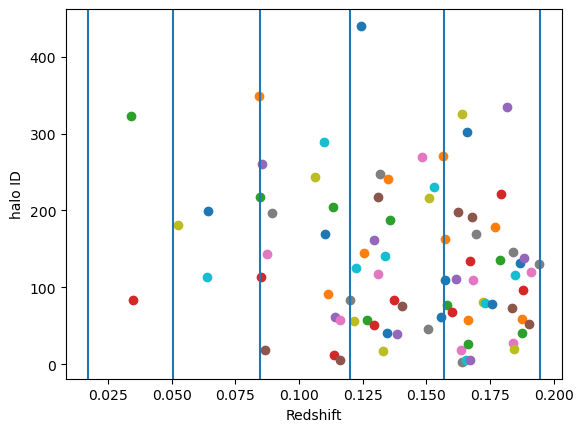

In [6]:
for cl_num in clusters.index[:]:
    #print(i, cl_num, clusters["z_true"][cl_num])
    plt.scatter(clusters["z_true"][cl_num], clusters["ihal"][cl_num])
    
for j in geometry["z_end"]:
    plt.axvline(j)
    
plt.xlabel("Redshift")
plt.ylabel("halo ID")
plt.show()

## (A) Single cluster: image and spectra

See https://cxc.cfa.harvard.edu/ciao/ahelp/dmstat.html for centroid searching method.

In [7]:
plt.hist2d(pho_list["RA"], pho_list["DEC"],
           bins=int(2*0.05*3600/4),
           norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

NameError: name 'pho_list' is not defined

<Figure size 640x480 with 0 Axes>

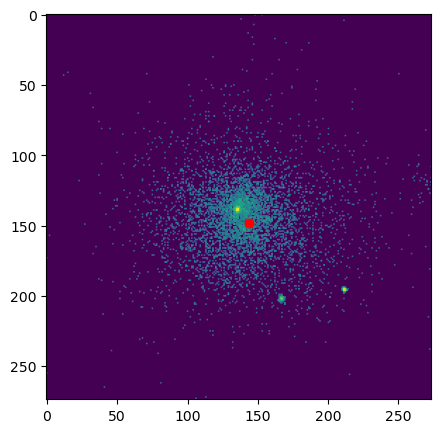

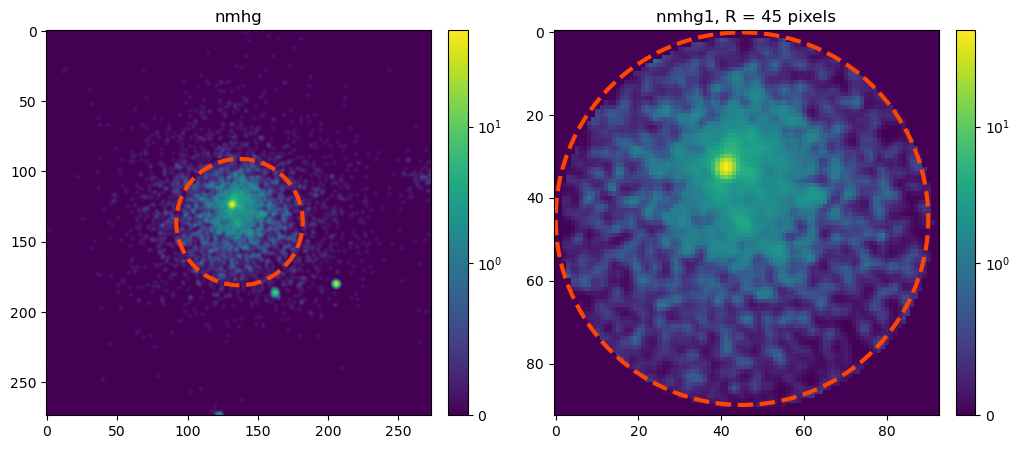

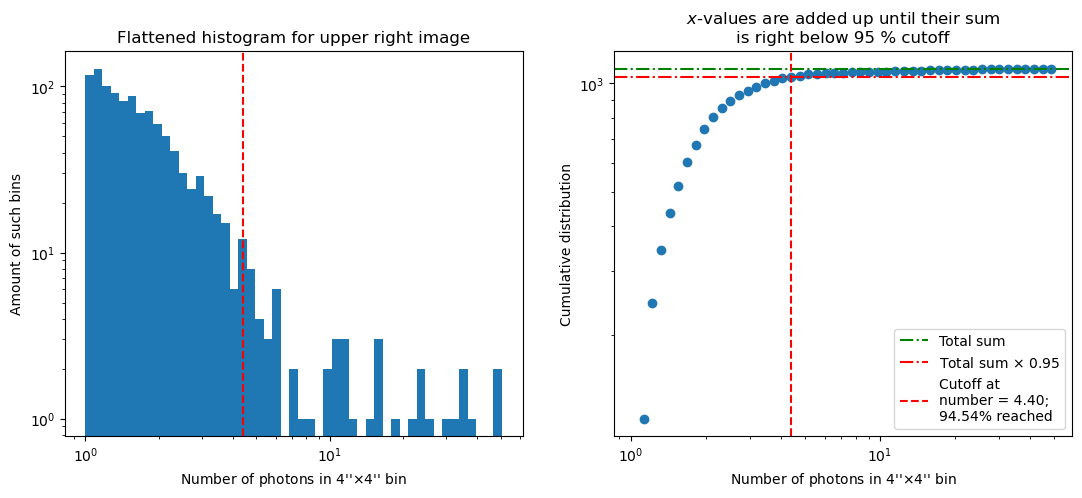

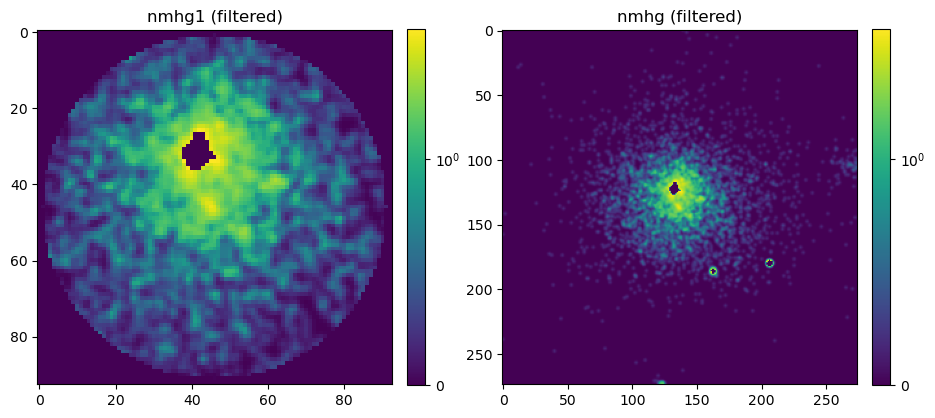

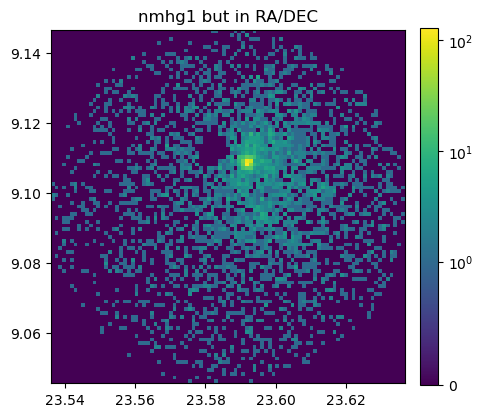

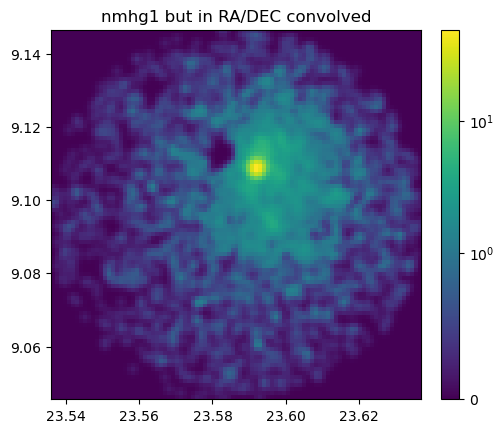

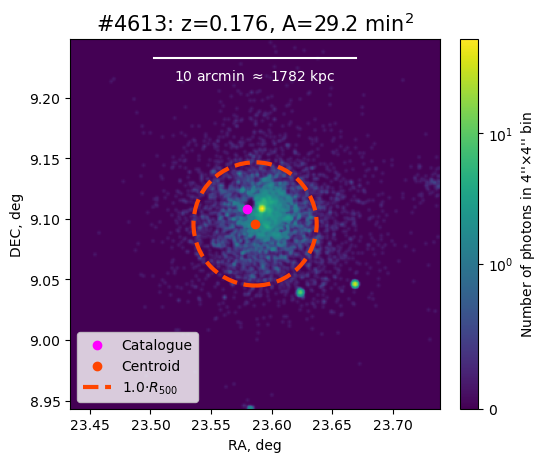

In [14]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(14,5))

cl_num = 4613
RRR = 1.0

#plt.subplot(121)
#pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
#                                        delete_bright_regions=False, draw=True,
                                        draw_additional=False)

plt.subplot(122)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=True, draw=True,
                                        draw_additional=True)

#display(pho_list)

plt.show()

In [ ]:
%run -i 'utils/scripts.py'

#logFile = x.Xset.openLog("newLogFile.txt")

display(clusters[clusters.index==cl_num])

plt.figure(figsize=(11, 5))

SP = create_spectrum_and_fit_it(cl_num, 
                                borders=[0.4, 7.0], 
                                BACKGROUND=False, 
                                inside_radius=RRR,
                                dbr=True,
                                Xplot=False, plot=True, draw_only=False)
plt.show()

print(SP)

x.AllData.show()
x.AllModels.show()

##### The use of the $\chi^2$ statistic for evaluating the goodness of fit. 

The data here are a series of observations of the luminosity of a star, with known error bars. Our model assumes that the brightness of the star does not vary; that is, all the scatter in the data is due to measurement error. $\chi^2_{\rm dof} \approx 1$ indicates that the model fits the data well (upper-left panel). $\chi^2_{\rm dof}$ much smaller than 1 (upper-right panel) is an indication that the errors are overestimated. $\chi^2_{\rm dof}$ much larger than 1 is an indication either that the errors are underestimated (lower-left panel) or that the model is not a good description of the data (lower-right panel). In this last case, it is clear from the data that the star’s luminosity is varying with time: this situation is be treated more fully in chapter 10. [Source](https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html)

[Kaastra (2017): On the use of C-stat in testing models for X-ray spectra](https://www.aanda.org/articles/aa/pdf/2017/09/aa29319-16.pdf)

[Dos and don’ts of reduced chi-squared](https://arxiv.org/pdf/1012.3754.pdf)

## (B)  Draw all 84 clusters

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='IMAGE')

plt.savefig('panels.png', format='png', dpi=200)
plt.show()

## (B0) Create `atable` for `xspec` with all 84 clusters

https://github.com/mbursa/xspec-table-models

`from xspec_table_models import XspecTableModelAdditive`

In [ ]:
%run -i 'utils/xspec_table_models.py'

radii = [0.15, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]  # in units of projected R_500

def atablemodel_input(CL_NUM, RADIUS):
    
    #plt.figure(figsize=(11,5))
    pho_list = extract_photons_from_cluster(CL_NUM, r = RADIUS, draw=False)
    #create_spectrum_and_fit_it(CL_NUM, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=RADIUS,
    #                            Xplot=False, plot=True, draw_only=False)
    #plt.show()
    
    photons1, energies_bins1 = np.histogram(pho_list["ENERGY"], bins = binning1)

    # specific fluxes [erg/s/cm2/keV] for the grid of energies1
    spec_flux = [a*b*(1.6*10**(-9))/10000/1000/c for a, b, c in zip(photons1, energies1, dE1)]
    
    return spec_flux * scale_by_distance(CL_NUM)

def scale_by_distance(CL_NUM) # normalization at 100 Mpc (z~0.024)
    
    D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(clusters.loc[CL_NUM]["z_true"]) # Mpc
    
    return (D_A/100)**2

N_channels1 = 4096
binning1 = np.logspace(np.log10(0.1), np.log10(12.0), N_channels1+1)
energies1 = [(a+b)/2 for a, b in zip(binning1[:-1], binning1[1:])]
dE1 = np.diff(binning1)

par1 = ('Number', list(clusters.index[:].values), False, True)
par2 = ('Radius', radii, False, True)

feets = XspecTableModelAdditive('RRCS_DB.fits', 'atableModel', np.array(energies1), [par1, par2], False)

index = 0
for cl_num in par1[1]:
    for radius in par2[1]:
        print(index, [cl_num, radius])
#for g in feets.generator():
#    index, param_values, param_indexes, energies = g
#    print(param_values)
        Iv = atablemodel_input(cl_num, radius)     # get the spectrum
        feets.write(index, Iv, False)    # write to FITS file
        index = index + 1

feets.save()

## (B1)  Fit  and draw all 84 clusters' spectra, with or without background

#### Considering: abundance = 0.3, cstat, exposure = 10000 s, weights = standard 

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='DATA')

plt.show()

## (B2)  Draw all 84 clusters' models (original and fitted), with or without background

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='MODEL')

plt.show()

## (C) Averaging

##### Check that abundance is FIXED (at 0.3 Solar) here:

In [8]:
%run -i 'utils/scripts.py'

#NNNN = 50
#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name = 'clean'

calculate_all_and_average_it(BACKGROUND=False, write_to_file=table_name)

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


1245 done


1380:   0%|          | 0/50 [00:00<?, ?it/s]

2904 done


3155:   0%|          | 0/50 [00:00<?, ?it/s]

4613 done


4967:   0%|          | 0/50 [00:00<?, ?it/s]

1838 done


2270:   0%|          | 0/50 [00:00<?, ?it/s]

171 done


187:   0%|          | 0/50 [00:00<?, ?it/s]

2471 done


2593:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


1380 done


1707:   0%|          | 0/50 [00:00<?, ?it/s]

3155 done


3886:   0%|          | 0/50 [00:00<?, ?it/s]

4967 done


5326:   0%|          | 0/50 [00:00<?, ?it/s]

2593 done


2603:   0%|          | 0/50 [00:00<?, ?it/s]

2270 done


2386:   0%|          | 0/50 [00:00<?, ?it/s]

187 done


350:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


5326 done


5443:   0%|          | 0/50 [00:00<?, ?it/s]

3886 done


3985:   0%|          | 0/50 [00:00<?, ?it/s]

1707 done


1819:   0%|          | 0/50 [00:00<?, ?it/s]

2603 done


2815:   0%|          | 0/50 [00:00<?, ?it/s]

350 done
2386 done


820:   0%|          | 0/50 [00:00<?, ?it/s]

2421:   0%|          | 0/50 [00:00<?, ?it/s]

5443 done


6001:   0%|          | 0/50 [00:00<?, ?it/s]

3985 done


6695:   0%|          | 0/50 [00:00<?, ?it/s]

1819 done


7364:   0%|          | 0/50 [00:00<?, ?it/s]

2815 done


8211:   0%|          | 0/50 [00:00<?, ?it/s]

820 done


9636:   0%|          | 0/50 [00:00<?, ?it/s]

2421 done


10551:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


6001 done


6496:   0%|          | 0/50 [00:00<?, ?it/s]

6695 done


6740:   0%|          | 0/50 [00:00<?, ?it/s]

7364 done


7409:   0%|          | 0/50 [00:00<?, ?it/s]

8211 done


8930:   0%|          | 0/50 [00:00<?, ?it/s]

9636 done


9836:   0%|          | 0/50 [00:00<?, ?it/s]

10551 done


10820:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


6496 done


6529:   0%|          | 0/50 [00:00<?, ?it/s]

6740 done


7191:   0%|          | 0/50 [00:00<?, ?it/s]

7409 done


7553:   0%|          | 0/50 [00:00<?, ?it/s]

8930 done


9240:   0%|          | 0/50 [00:00<?, ?it/s]

9836 done


10018:   0%|          | 0/50 [00:00<?, ?it/s]

10820 done


10842:   0%|          | 0/50 [00:00<?, ?it/s]

6529 done


6582:   0%|          | 0/50 [00:00<?, ?it/s]

7191 done


7308:   0%|          | 0/50 [00:00<?, ?it/s]

7553 done


7996:   0%|          | 0/50 [00:00<?, ?it/s]

10018 done


10548:   0%|          | 0/50 [00:00<?, ?it/s]

9240 done


9389:   0%|          | 0/50 [00:00<?, ?it/s]

10842 done


10928:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


6582 done


11141:   0%|          | 0/50 [00:00<?, ?it/s]

7308 done


11599:   0%|          | 0/50 [00:00<?, ?it/s]

7996 done


13334:   0%|          | 0/50 [00:00<?, ?it/s]

9389 done


14434:   0%|          | 0/50 [00:00<?, ?it/s]

10548 done


14726:   0%|          | 0/50 [00:00<?, ?it/s]

10928 done


16666:   0%|          | 0/50 [00:00<?, ?it/s]

11141 done
11599 done


11272:   0%|          | 0/50 [00:00<?, ?it/s]

11847:   0%|          | 0/50 [00:00<?, ?it/s]

13334 done


13675:   0%|          | 0/50 [00:00<?, ?it/s]

14434 done


14559:   0%|          | 0/50 [00:00<?, ?it/s]

14726 done


14857:   0%|          | 0/50 [00:00<?, ?it/s]

16666 done


17017:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


11847 done


12045:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


11272 done


11428:   0%|          | 0/50 [00:00<?, ?it/s]

13675 done


13751:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


14559 done


14660:   0%|          | 0/50 [00:00<?, ?it/s]

17017 done


17086:   0%|          | 0/50 [00:00<?, ?it/s]

14857 done


14936:   0%|          | 0/50 [00:00<?, ?it/s]

12045 done


12296:   0%|          | 0/50 [00:00<?, ?it/s]

13751 done


14038:   0%|          | 0/50 [00:00<?, ?it/s]

11428 done


11468:   0%|          | 0/50 [00:00<?, ?it/s]

14660 done


14667:   0%|          | 0/50 [00:00<?, ?it/s]

17086 done


17174:   0%|          | 0/50 [00:00<?, ?it/s]

14936 done


15138:   0%|          | 0/50 [00:00<?, ?it/s]

12296 done


17365:   0%|          | 0/50 [00:00<?, ?it/s]

14038 done


17654:   0%|          | 0/50 [00:00<?, ?it/s]

11468 done


18610:   0%|          | 0/50 [00:00<?, ?it/s]


17174 done14667 done
15138 done
17365 done


17415:   0%|          | 0/50 [00:00<?, ?it/s]

17654 done


17964:   0%|          | 0/50 [00:00<?, ?it/s]

18610 done


19523:   0%|          | 0/50 [00:00<?, ?it/s]

17964 done


18073:   0%|          | 0/50 [00:00<?, ?it/s]

17415 done


17421:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


19523 done


19771:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


17421 done


17638:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


18073 done


18589:   0%|          | 0/50 [00:00<?, ?it/s]

17638 done
19771 done


19787:   0%|          | 0/50 [00:00<?, ?it/s]

18589 done
19787 done


  0%|          | 0/84 [00:00<?, ?it/s]

,$T_{500}$,$T_{spec}$,$\Delta T_{spec}$,$L_{bol}$,$L_{fit}$,$\Delta L_{fit}$,$E_{av}$,$\Delta E_{av}$,$Z$,$\Delta Z$
171,2.44633,2.217794,0.293925,0.707698,0.732559,0.042344,1.072283,0.019421,0.3,5.551115e-17
187,2.43074,2.144158,0.177101,0.532571,0.720362,0.037695,1.022875,0.016868,0.3,5.551115e-17
350,3.21771,3.158178,0.334312,1.515690,1.323350,0.056597,1.131255,0.020391,0.3,5.551115e-17
820,3.57076,3.313412,0.304861,0.972861,0.951834,0.044321,1.132377,0.017283,0.3,5.551115e-17
1245,2.78095,3.056635,0.639606,0.452088,0.501350,0.038896,1.118168,0.030631,0.3,5.551115e-17
...,...,...,...,...,...,...,...,...,...,...
18589,2.22808,2.150721,0.093724,0.537683,0.473869,0.009740,1.052250,0.007384,0.3,5.551115e-17
18610,2.26553,2.401425,0.108244,0.455429,0.358524,0.009041,1.055352,0.010446,0.3,5.551115e-17
19523,2.39539,2.768699,0.231856,0.231120,0.175066,0.008393,1.095993,0.016969,0.3,5.551115e-17
19771,2.61661,2.923384,0.074554,0.651073,0.560228,0.007497,1.119233,0.004518,0.3,5.551115e-17


<Figure size 640x480 with 0 Axes>

#### Reading from table:

In [9]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name = 'clean'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

### (C0) Spectral temperature compared to $T_{500}$

In [10]:
#DAS = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(redshifts).value # Mpc
#(DAS*[1+qwerty for qwerty in redshifts])**2/100000 # Mpc^2
#plt.scatter(DAS*[1+qwerty for qwerty in redshifts], (DAS*[1+qwerty for qwerty in redshifts])**2/100000 )
#plt.xlabel("$D_{comoving} = D_A \cdot (1+z), Mpc$", fontsize=12)
#plt.ylabel("$[D_A (1+z)]^2 \cdot 10^{-5}, Mpc^2$", fontsize=12)

<Figure size 640x480 with 0 Axes>

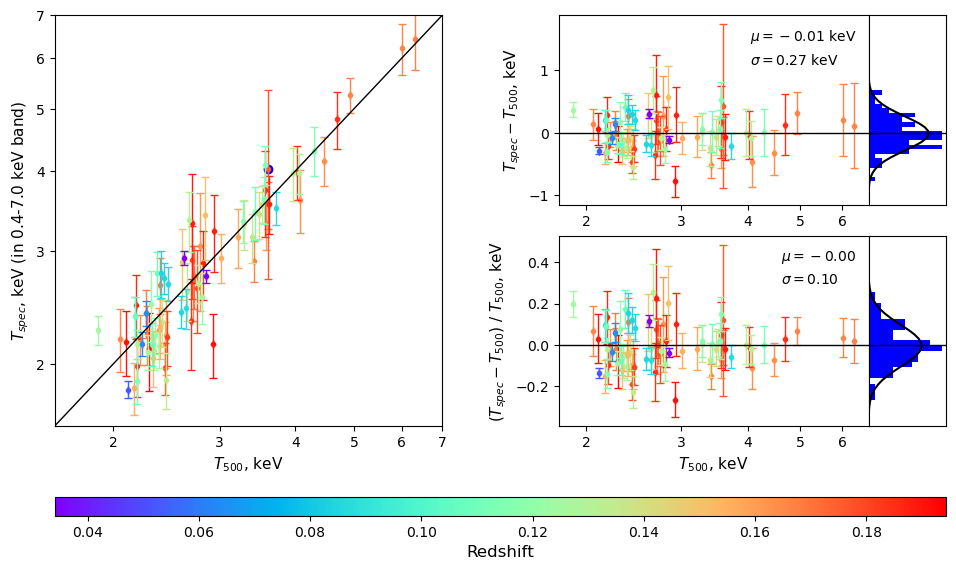

In [16]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

t500s = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels(x_array=t500s,
                  y_array=temp_usr,
                  x_label="$T_{500}$, keV",
                  y_label_left="$T_{spec}$, keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{spec} - T_{500}$, keV",
                  y_label_right_down="$(T_{spec} - T_{500}) \ / \ T_{500}$, keV",
                  clr='b',
                  NnNn=NNNN,
                  cmap=redshifts,
                  cmap_label="Redshift")

#plt.savefig('figures/T_vs_T500.pdf', format='pdf')
plt.show()

### (C1) Temperature and luminosity from fit as a functions of $T_{500}$ and $L_{500}$ from several fits.

In [12]:
masses = [clusters.loc[i]["M500"]/10**14 for i in clusters.index]
norm = matplotlib.colors.Normalize(vmin=min(masses), vmax=max(masses), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
mass_colour = np.array([(mapper.to_rgba(v)) for v in masses])

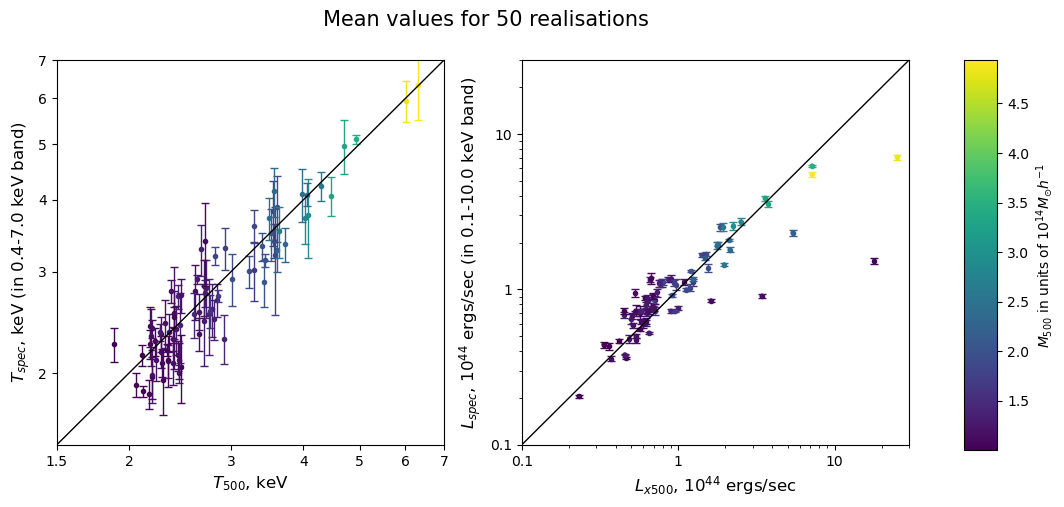

In [53]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

xx = [a[0] for a in temp_usr]
yy = [a[1] for a in temp_usr]
y_err = [a[2] for a in temp_usr]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.ylabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)

plt.xlim(1.5, 7)
plt.ylim(1.5, 7)

plt.xscale("log")
plt.yscale("log")

plt.xticks([plt.gca().get_xlim()[0],2,3,4,5,6,7], [plt.gca().get_xlim()[0],2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

#plt.scatter(2.60178, 3.985203132730008, color='red')

plt.subplot(122)

xx = [a[0] for a in lumin_usr]
yy = np.array([a[1] for a in lumin_usr])*(np.ones(len(redshifts))+redshifts)**2
y_err = [a[2] for a in lumin_usr]*(np.ones(len(redshifts))+redshifts)**2

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.15, 30)
plt.ylim(0.15, 30)

plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.yticks([0.1, 1, 10], [0.1, 1, 10])

#plt.axvline(0.592084)
#plt.axhline(0.2546419982104965)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

plt.savefig('figures/T_vs_T_and_L_vs_L.pdf', format='pdf')

plt.show()

#L-T, L-M, T-M

#### Note how small are errors for luminosities!

### (C2) Average energy as a function of **mean** temperature

##### aven_usr: [ $E_{av}, \Delta E$ ], temp_usr: [ $T_{sim}, T_{spec}, \Delta T$ ]

[How to get confidence intervals from curve_fit](https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit)

[Correct fitting with scipy curve_fit including errors in x?](https://stackoverflow.com/questions/26058792/correct-fitting-with-scipy-curve-fit-including-errors-in-x)

[How to plot 1-Sigma Prediction Interval for scipy.odr](https://stackoverflow.com/questions/60889680/how-to-plot-1-sigma-prediction-interval-for-scipy-odr)

[Confidence interval for exponential curve fit](https://stackoverflow.com/questions/24633664/confidence-interval-for-exponential-curve-fit/37080916#37080916)

0.8571428571428571 0.14285714285714285 84


<Figure size 640x480 with 0 Axes>

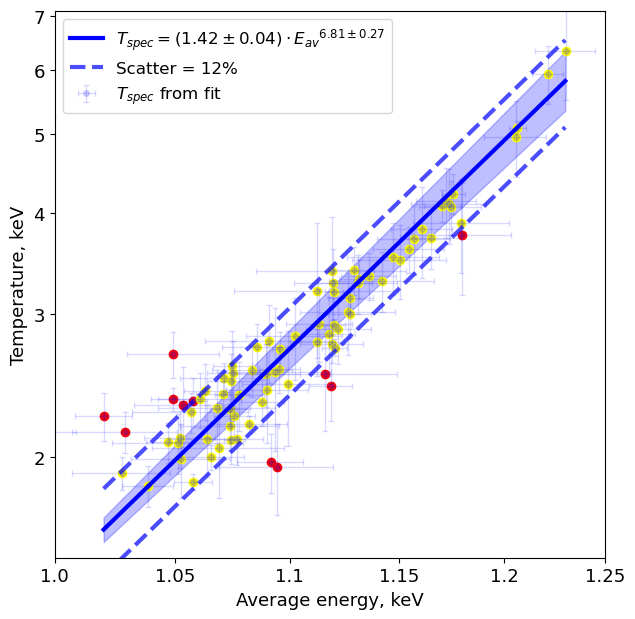

In [14]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr]
x_err = [a[1] for a in aven_usr]
yy1 = [a[0] for a in temp_usr]
yy2 = [a[1] for a in temp_usr]
y2_err = [a[2] for a in temp_usr]

lll = np.linspace(1.02, 1.23, 100)        

draw_line(xx, x_err, yy2, y_es=y2_err, 
          clr = 'blue', 
          l4dots = '$T_{spec}$ from fit', 
          l4legend = 'T_{{spec}}',
          argument='E_{{av}}',
          with_intervals = True,
          with_scatter=True)

#draw_line(xx, x_err, yy1, y_es=np.array(yy1)*0, 
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}',
#          argument='E_{{av}}',
#          with_scatter=True)        
        
plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [2,3,4,5,6,7]

plt.ylim(min(Ytix)-0.5, max(Ytix)+0.1)
plt.xlim(1.0, 1.25)

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=2, fontsize = 12)

ooofff = (plt.gca().get_xlim(), plt.gca().get_ylim())

plt.savefig('figures/T_vs_Eav.pdf', format='pdf')
plt.show()

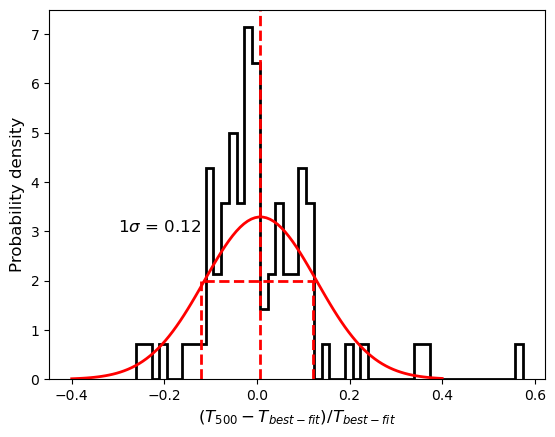

0.12123908172671989

In [15]:
%run -i 'utils/draw.py'
calculate_scatter(xx, yy2, plot=True)

### How average energy changes with redshift?

In [ ]:
NNNN = 40

table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_z =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_z = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_z =  list(zip(read_table[7].values(), read_table[8].values()))

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(9.1,9.1))

lll = np.linspace(0.95, 1.25, 100)

xx1 = [a[0] for a in aven_usr_z]
x1_err = [a[1] for a in aven_usr_z]
yy0 = [a[0] for a in temp_usr_z]
yy1 = [a[1] for a in temp_usr_z]
y1_err = [a[2] for a in temp_usr_z]

draw_line(xx1, x1_err, yy1, y1_err, 
          clr = 'green', 
          l4dots = '$T_{spec}$ at $z=z_{true}$', 
          l4legend = 'T_{{spec}}',
          argument = 'E_{{av}}',
          with_scatter=False,
          with_intervals=False,
          u4et_oshibok=True)


xx2 = [a[0] for a in aven_usr]
x2_err = [a[1] for a in aven_usr]
yy0 = [a[0] for a in temp_usr]
yy2 = [a[1] for a in temp_usr]
y2_err = [a[2] for a in temp_usr]

draw_line(xx2, x2_err, yy2, y2_err, 
          clr = 'red', 
          l4dots = '$T_{spec}$ at $z=0$', 
          l4legend = 'T_{{spec}}',
          argument = 'E_{{av}}', 
          with_scatter=False,
          with_intervals=False,
          u4et_oshibok=True)        
        
plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [1,2,3,4,5,6,7]

#plt.ylim(min(Ytix), max(Ytix)+0.8)
#plt.xlim(0.9, 1.35)

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

for i in range(0, len(aven_usr)):
    plt.plot([xx1[i]+0.000454, xx2[i]+0.000454], 
             [yy1[i], yy2[i]], 
             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=4, fontsize = 12)

plt.show()

## (D) Impact of abundance fixation

#### Be sure to check that abundance is FREE here:

In [ ]:
%run -i 'utils/scripts.py'

NNNN = 40

calculate_all_and_average_it(NNNN, write_to_file='1_ab-free_cstat_10ks_standard-'+str(NNNN))

#### Reading from table:

In [ ]:
table_name = '1_ab-free_cstat_10ks_standard-'+str(NNNN)+'_z=0'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_free_abundance =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_free_abundance = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_free_abundance =  list(zip(read_table[7].values(), read_table[8].values()))

In [ ]:
abund_usr_free_abundance = list(zip(read_table[9].values(), read_table[10].values()))

In [ ]:
abundances = [a[0] for a in abund_usr_free_abundance]
#norm_abund = matplotlib.colors.Normalize(vmin=min(abundances), vmax=max(abundances), clip=True)
#mapper_abund = cm.ScalarMappable(norm=norm_abund, cmap='jet_r')
#abund_colour = np.array([(mapper_abund.to_rgba(v)) for v in abundances])

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_free_abundance,
                  x_label="$T_{spec}$ with abundance FIXED at 0.3 Solar, keV",
                  y_label_left="$T_{spec}$ with FREE abundance, keV",
                  y_label_right_up="$T_{free \ Z} - T_{fixed \ Z}$, keV",
                  y_label_right_down="$(T_{free \ Z} - T_{fixed \ Z}) \ / \ T_{fixed \ Z}$, keV",
                  clr='b',
                  NnNn = NNNN,
                  cmap=abundances,
                  cmap_label = "Abundance in units of 1 Solar" )

### Comparing fixed and free abundance impact on $T_{spec}(E_{av})$

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(9.1,9.1))

lll = np.linspace(2, 7, 100) 


xx1 = [a[0] for a in aven_usr]
x1_err = [a[1] for a in aven_usr]
yy0 = [a[0] for a in temp_usr]
yy1 = [a[1] for a in temp_usr]
y1_err = [a[2] for a in temp_usr]     

draw_line(yy0, np.zeros(84), yy1, y1_err, 
          clr = 'dodgerblue', 
          l4dots = '$T_{spec}$ (FIXED abundance)', 
          l4legend = 'T_{{spec}}^{{Zfixed}}',
          argument = 'T_{{500}}',
          with_scatter=True,
          with_intervals=True,
          u4et_oshibok=True)


xx2 = [a[0] for a in aven_usr_free_abundance]
x2_err = [a[1] for a in aven_usr_free_abundance]
yy0 = [a[0] for a in temp_usr_free_abundance]
yy2 = [a[1] for a in temp_usr_free_abundance]
y2_err = [a[2] for a in temp_usr_free_abundance]

draw_line(yy0, np.zeros(84), yy2, y2_err, 
          clr = 'orangered', 
          l4dots = '$T_{spec}$ (FREE abundance)', 
          l4legend = 'T_{{spec}}^{{Zfree}}', 
          argument = 'T_{{500}}',
          with_scatter=True,
          with_intervals=True,
          u4et_oshibok=True)        
        
plt.xlabel("$T_{500}$, keV", fontsize=13)
plt.ylabel("$T_{spec}$, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

tix = [1,2,3,4,5,6,7,8,9]

plt.plot([tix[0],tix[-1]],[tix[0],tix[-1]], linewidth=3, color='black', ls = '--', label='$T_{spec}=T_{500}$')

plt.xlim(min(tix), max(tix))
plt.ylim(min(tix), max(tix))

plt.xticks(tix, tix, size=13)
plt.yticks(tix, tix, size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=2, fontsize = 12)

plt.show()

In [ ]:
%run -i 'utils/draw.py'

calculate_scatter(xx2, yy2, plot=True)

## (E) Impact of exposure time with FIXED abundance

##### Previously it was set to 10 ks, now it is changed to 2 ks (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='2_ab-fix_cstat_02ks_standard')

#### Reading from table:

In [ ]:
table_name = '2_ab-fix_cstat_02ks_standard'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_smaller_exposure_2ks =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_smaller_exposure_2ks = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_smaller_exposure_2ks =  list(zip(read_table[7].values(), read_table[8].values()))

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_smaller_exposure_2ks,
                  x_label="$T_{spec}$ with 10 ks exposure, keV",
                  y_label_left="$T_{spec}$ with 2 ks exposure, keV",
                  y_label_right_up="$T_{2 \ ks} - T_{10 ks}$, keV",
                  y_label_right_down="$(T_{2 \ ks} - T_{10 \ ks}) \ / \ T_{10 \ ks}$, keV",
                  clr='g',
                  NnNn = NNNN)

#### CHECKED: almost no difference for 5 ks. (was relevant for R_vir)

## (E) Impact of statistics with FIXED abundance and 10 ks exposure

#### Previously it was `cstat`, now it is $\chi^2$ (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='3_ab-fix_chisq_10ks_standard')

#### Reading from table:

In [ ]:
table_name = '3_ab-fix_chisq_10ks_standard'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_chisq =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_chisq = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_chisq =  list(zip(read_table[7].values(), read_table[8].values()))

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_chisq,
                  x_label="$T_{spec}$ with cstat, keV",
                  y_label_left="$T_{spec}$ with $\chi^2$, keV",
                  y_label_right_up="$T_{\chi^2} - T_{cstat}$, keV",
                  y_label_right_down="$(T_{\chi^2} - T_{cstat}) \ / \ T_{cstat}$, keV",
                  clr='r',
                  NnNn = NNNN)

## (F) Impact of weights with FIXED abundance, 10 ks exposure and `cstat`

#### Previously it was `standard`, now it is `churazov` (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='4_ab-fix_cstat_10ks_churazov')

#### Reading from table:

In [ ]:
table_name = '4_ab-fix_cstat_10ks_churazov'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_churazov =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_churazov = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_churazov =  list(zip(read_table[7].values(), read_table[8].values()))

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_churazov,
                  x_label="$T_{spec}$ with `standard` weights, keV",
                  y_label_left="$T_{spec}$ with `churazov` weights, keV",
                  y_label_right_up="$T_{st} - T_{ch}$, keV",
                  y_label_right_down="$(T_{st} - T_{ch}) \ / \ T_{ch}$, keV",
                  clr='purple',
                  NnNn = NNNN)

These 4 plots were at first plotted for $R_{vir}$, then for $R_{500}$ (there was a mistake for the second time: it was also for $R_{vir}$). Now (third time) it is for $R_{500}$.

## (G) Adding background

[ABSOLUTE MEASUREMENT OF THE UNRESOLVED COSMIC X-RAY BACKGROUND
IN THE 0.5–8 KEV BAND WITH CHANDRA](https://arxiv.org/pdf/astro-ph/0512542.pdf)

[CHANDRA SPECTRA OF THE SOFT X-RAY DIFFUSE BACKGROUND](https://iopscience.iop.org/article/10.1086/345347/pdf)

`'5_ab-fix_cstat_10ks_standard_BKG-50_with_area'`

In [ ]:
%run -i 'utils/scripts.py'

calculate_all_and_average_it(BACKGROUND=True, write_to_file='5_with_bkg1')

#### Reading from table:

In [16]:
NNNN = 50

#table_name = '5_ab-fix_cstat_10ks_standard_BKG-'+str(NNNN)+'_z=0'
table_name = 'withbkg'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_with_bkg = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_with_bkg =  list(zip(read_table[7].values(), read_table[8].values()))

#### Experiments with constant before background:

In [24]:
display(pd.DataFrame(read_table))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
171,2.44633,1.795272,0.309434,0.707698,69.096494,5.610517,1.266406,0.012528,27.841089,46.515233,8.515602,0.000626,0.000080,27.841089,29.990821,2.444843
187,2.43074,1.484019,0.410105,0.532571,60.290141,5.435125,1.183048,0.011471,24.458494,80.510954,13.560191,0.000507,0.000138,24.458494,26.110471,2.353828
350,3.21771,3.246733,0.239856,1.515690,76.496614,5.920267,1.264342,0.018206,34.715563,29.398321,11.665169,0.001384,0.000063,34.715563,32.857069,2.542856
820,3.57076,3.164956,0.446030,0.972861,70.446489,9.460469,1.274084,0.039410,32.525843,41.735901,5.185528,0.000789,0.000044,32.525843,29.540442,3.966988
1245,2.78095,3.482696,0.917711,0.452088,58.109418,6.590674,1.294980,0.039486,25.984376,33.972769,7.940094,0.000539,0.000042,25.984376,23.883346,2.732047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,2.22808,2.197786,0.106847,0.537683,42.756908,2.234449,1.207750,0.006610,109.417501,152.023422,20.004688,0.003706,0.000126,109.417501,109.148160,5.703963
18610,2.26553,2.618922,0.200686,0.455429,43.188234,2.537769,1.253090,0.015084,114.070724,161.744421,21.859870,0.002612,0.000134,114.070724,108.907496,6.399445
19523,2.39539,2.199619,0.251158,0.231120,39.182368,3.225688,1.353304,0.030797,61.033100,85.021182,7.299738,0.000656,0.000046,61.033100,57.813829,4.759430
19771,2.61661,2.848690,0.127417,0.651073,40.331321,1.118913,1.249516,0.007685,359.968601,368.579490,37.398186,0.013760,0.000222,359.968601,359.293482,9.967838


In [41]:
area_usr_with_bkg = list(zip(read_table[9].values(), read_table[10].values(), read_table[11].values()))
norm_usr_with_bkg = list(zip(read_table[12].values(), read_table[13].values()))
pbkg_usr_with_bkg = list(zip(read_table[14].values(), read_table[15].values(), read_table[16].values()))

In [42]:
ORIGA = np.array([n[0] for n in area_usr_with_bkg])
SPECA = np.array([n[1] for n in area_usr_with_bkg])
SPECA_delta = np.array([n[2] for n in area_usr_with_bkg])

NORM = np.array([n[0] for n in norm_usr_with_bkg])
NORM_delta = np.array([n[1] for n in norm_usr_with_bkg])

ORIGB = np.array([n[0] for n in pbkg_usr_with_bkg])
SPECB = np.array([n[1] for n in pbkg_usr_with_bkg])
SPECB_delta = np.array([n[2] for n in pbkg_usr_with_bkg])

In [65]:
SKOLKO1 = SPECA/ORIGA
SKOLKO1_delta = SPECA_delta/ORIGA

SKOLKO2 = SPECB/ORIGB
SKOLKO2_delta = SPECB_delta/ORIGB

print(SKOLKO1, SKOLKO2)

[1.67074041 3.29173804 0.84683405 1.28316126 1.30743064 1.30433735
 0.39905384 1.00516152 1.37106446 1.15878422 1.48722443 0.64645655
 0.81698551 1.00662782 1.03754208 1.62391284 1.19377161 1.16178659
 1.52780055 1.35237257 0.752663   1.70091854 0.98220312 0.97520184
 1.26193676 1.64277424 1.16941    0.89295437 0.62546069 1.70877223
 1.43333995 0.91605481 0.86800343 1.24964895 1.67491096 2.0442731
 1.26478877 1.01185576 2.00399593 1.46802213 2.52605853 1.76321294
 1.45869515 1.06032142 1.27000551 1.46599389 1.27085818 1.53358595
 0.91571594 1.12754965 0.95756286 1.10921248 1.51271982 1.00783517
 1.22779748 1.14801249 1.17546769 2.10148359 1.66383031 1.09098073
 1.03535658 3.03516204 1.44026877 1.31408726 1.45063471 1.17171919
 1.10026247 1.06742811 1.36949957 0.91843193 1.39134616 0.86173161
 0.63377693 1.04274697 0.84122552 1.03303857 0.90790007 0.75678153
 1.37162875 1.38938854 1.41793104 1.39303397 1.02392122 0.81881547] [1.07721437 1.06754207 0.94646511 0.90821451 0.91914257 1.0966

In [73]:
SKOLKO1*NORM

array([0.00104666, 0.00167055, 0.00117197, 0.00101207, 0.00070486,
       0.0007575 , 0.00077167, 0.0026202 , 0.00041119, 0.00488175,
       0.00099261, 0.0012321 , 0.00319087, 0.00058913, 0.00325453,
       0.00125404, 0.00078139, 0.00092732, 0.0011398 , 0.00186844,
       0.00040903, 0.00127141, 0.00041894, 0.00068784, 0.00097267,
       0.00086245, 0.00165656, 0.00045787, 0.00110454, 0.00106374,
       0.00068272, 0.00052886, 0.00111967, 0.00106294, 0.00054616,
       0.0007419 , 0.00073411, 0.00041992, 0.00166508, 0.00131599,
       0.00323574, 0.00183436, 0.00148251, 0.00258614, 0.0013694 ,
       0.0014826 , 0.00187968, 0.00171019, 0.0020196 , 0.00100457,
       0.00176732, 0.00055008, 0.0013012 , 0.00085433, 0.00167337,
       0.00228019, 0.00067875, 0.00116693, 0.00062855, 0.00078903,
       0.0012276 , 0.00364186, 0.00389575, 0.0035066 , 0.00284792,
       0.00437237, 0.0018245 , 0.00179872, 0.00170667, 0.00175707,
       0.00205527, 0.00154998, 0.00089334, 0.00237787, 0.00147

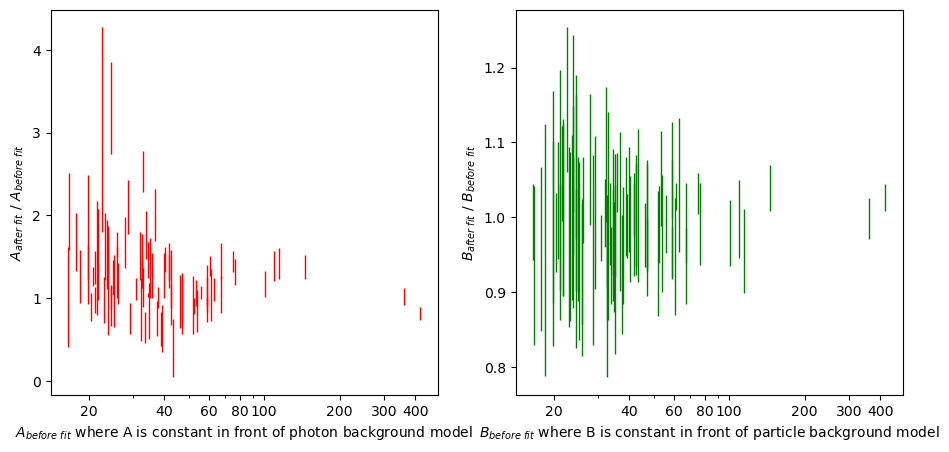

In [95]:
plt.figure(figsize = (11,5))

plt.subplot(121)
plt.errorbar(ORIGA, SKOLKO1, yerr=SKOLKO1_delta, elinewidth=1, fmt='none', color='red')
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$A_{before \ fit}$ where A is constant in front of photon background model")
plt.ylabel("$A_{after \ fit} \ / \ A_{before \ fit}$")
xgtr = np.append(np.linspace(20, 100, 5).astype(int), [200,300,400])
plt.xticks(xgtr, xgtr)
#ygtr = [1,2,3,4,5,6,7]
#plt.yticks(ygtr, ygtr)

plt.subplot(122)
plt.errorbar(ORIGB, SKOLKO2, yerr=SKOLKO2_delta, elinewidth=1, fmt='none', color='green')
plt.xscale("log")
plt.xlabel("$B_{before \ fit}$ where B is constant in front of particle background model")
plt.ylabel("$B_{after \ fit} \ / \ B_{before \ fit}$")
plt.xticks(xgtr, xgtr)
plt.show()

#### Making the number of averaged $T / L / E_{av}$ without background the same:

In [18]:
#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)

#read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
#temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
#lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
#aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

<Figure size 640x480 with 0 Axes>

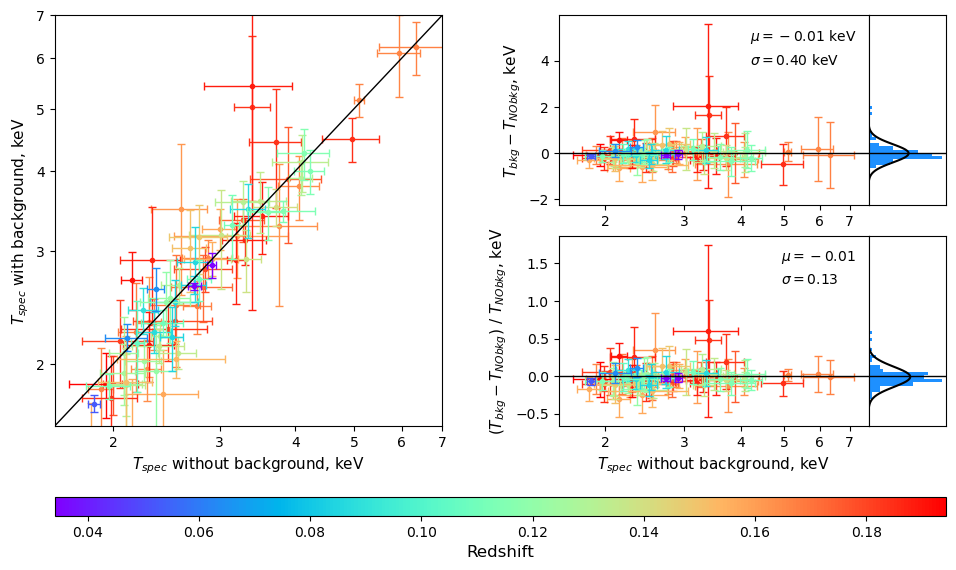

In [36]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_with_bkg,
                  x_label="$T_{spec}$ without background, keV",
                  y_label_left="$T_{spec}$ with background, keV",
                  y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                  y_label_right_down="$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$, keV",
                  clr='dodgerblue',
                  NnNn = NNNN,
                  cmap = redshifts,
                  cmap_label="Redshift")

#fig.colorbar(mappable=mapper_area, cax=ax6, orientation="horizontal",  ticks=[1,2,3,4,5, 6]).set_label("$A_{after \ fit} \ / \ A_{before \ fit}$ where A is constant in front of background model", fontsize=12)
#ax6.set_xticklabels([1,2,3,4,5,6])

#plt.savefig('figures/T_with_bkg_vs_T_without_bkg.pdf', format='pdf')
plt.show()

#### How fitted temperature with added background varies depending on impact of AGNs in background?

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

for AGN in [0.0, 0.25, 0.5, 0.75, 1.0]:

    NNNN = 1

    table_name = '5_BKG-'+str(NNNN)+'-AGN='+str(AGN)

    read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()

    temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))

    draw_three_panels(x_array=temp_usr, 
                      y_array=temp_usr_with_bkg,
                      x_label="$T_{spec}$ without background, keV",
                      y_label_left="$T_{spec}$ with background, keV",
                      y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                      y_label_right_down="$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$",
                      clr='dodgerblue',
                      NnNn = NNNN,
                      cmap_by_redshifts=True)
    
    plt.suptitle(f"    Mean values for {NNNN} realisations \n $const$ before AGN in model for background: {AGN}", fontsize=15)

    #plt.savefig(str(AGN)+".png", format="png")
    plt.show()

In [ ]:
AGNs = [0.0, 0.25, 0.5, 0.75, 1.0]
T_AGNs = [0.12, 0.08, 0.02, -0.02, -0.08]
dT_AGNs = [0.20, 0.16, 0.18, 0.20, 0.22 ]

In [ ]:
plt.errorbar(AGNs, T_AGN, dT_AGNs, elinewidth=1, capsize=3)
plt.xlabel("Fraction of unresolved AGNs \n (`const` before `powerlaw` in background model)", fontsize=12)
plt.ylabel("$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$", fontsize=12)
plt.axhline(0, linewidth=1, color='black', ls = '--')
plt.show()

### Comparing clear $T$ and $L$ from fitting (not simulations) and them with background added:

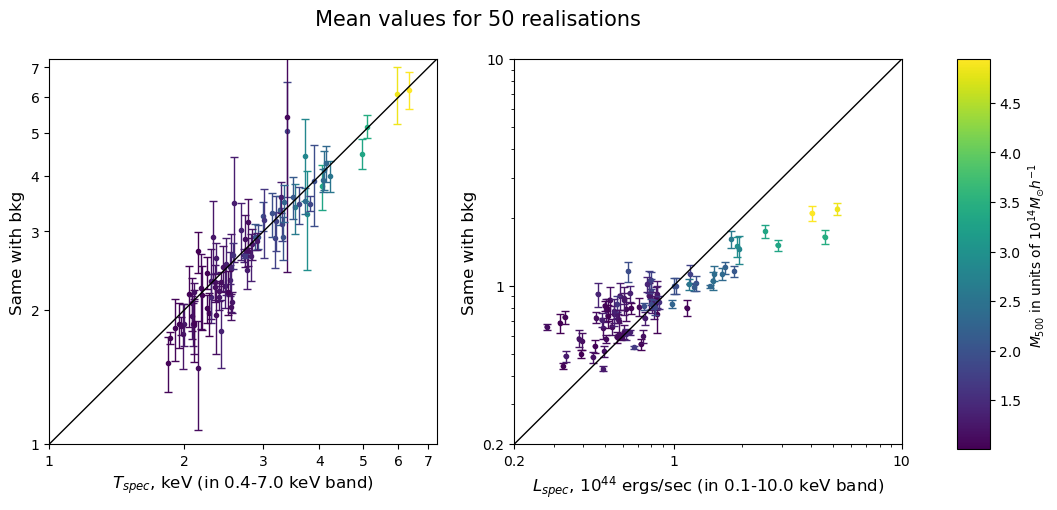

In [54]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

#xx = [a[0] for a in temp_usr_with_bkg]
xx = [a[1] for a in temp_usr]
yy = [a[1] for a in temp_usr_with_bkg]
y_err = [a[2] for a in temp_usr_with_bkg]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.xlabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xlim(1., 7.3)
plt.ylim(1., 7.3)

plt.xscale("log")
plt.yscale("log")

plt.xticks([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])
plt.yticks([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])

plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)


plt.subplot(122)

#xx = [a[0] for a in lumin_usr_with_bkg]
xx = [a[1] for a in lumin_usr]
yy = [a[1]/100 for a in lumin_usr_with_bkg]*(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)
y_err = [a[2]/100 for a in lumin_usr_with_bkg]*(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.2, 10)
plt.ylim(0.2, 10)

plt.xticks([0.2, 1, 10], [0.2, 1, 10])
plt.yticks([0.2, 1, 10], [0.2, 1, 10])

plt.plot( plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

#plt.savefig('figures/T_vs_T_and_L_vs_L_with_bkg.pdf', format='pdf')
plt.show()

### Average energy as a function of **mean** temperature with background added:

<Figure size 640x480 with 0 Axes>

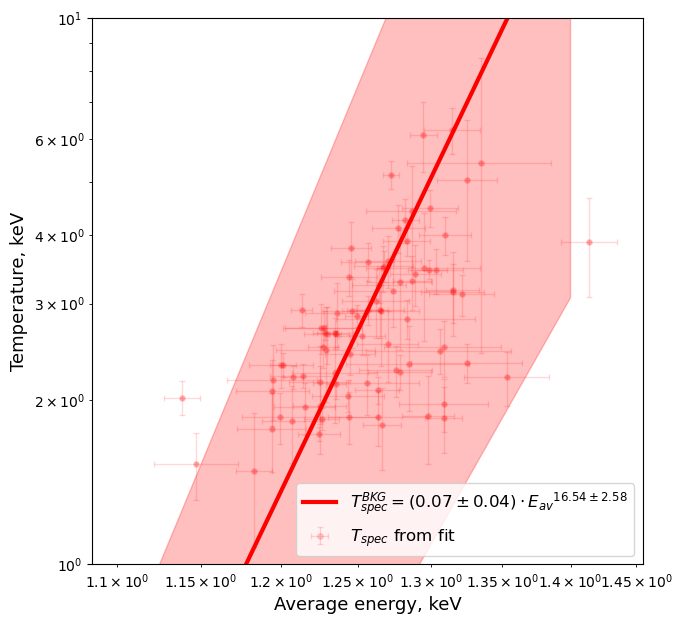

In [98]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr_with_bkg]
x_err = [a[1] for a in aven_usr_with_bkg]
yy1 = [a[0] for a in temp_usr_with_bkg]
yy2 = [a[1] for a in temp_usr_with_bkg]
y2_err = [a[2] for a in temp_usr_with_bkg]

#def func(x, a, b):
#    return a * x**b

lll = np.linspace(1.1, 1.4, 100)

draw_line(xx, x_err, yy2, y_es=y2_err, 
          clr = 'red', 
          l4dots = '$T_{spec}$ from fit', 
          l4legend = 'T_{{spec}}^{{BKG}}',
          argument='E_{{av}}',
          with_scatter=False)

#draw_line(xx, x_err, yy1, y_es=np.array(yy1)*0, 
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}^{{BKG}}',
#          argument='E_{{av}}', 
#          with_scatter=True)  

plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
#plt.ylim(0.9, 1.3)

ddd=False

if ddd:
    plt.plot(lll, 2.05*lll**5.1,  
         color='blue', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}} = (2.05 \pm 0.03) \cdot {{E_{{av}}}}^{{5.1 \pm 0.2}}$')
    plt.fill_between(lll, 
                     2.02*lll**4.9, 
                     2.08*lll**5.3, 
                     interpolate=False, alpha=0.25, color='blue')
    
if ddd:
    plt.plot(lll, 2.32*lll**4.8,  
         color='green', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{500}} = (2.32 \pm 0.06) \cdot {{E_{{av}}}}^{{4.8 \pm 0.3}}$')
    plt.fill_between(lll, 
                     2.26*lll**4.5, 
                     2.38*lll**5.1, 
                     interpolate=False, alpha=0.25, color='green')  
    

#plt.xticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2], size=13)
#plt.yticks([1,2,3,4,5,6,7], [1,2,3,4,5,6,7], size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

plt.legend(loc=4, fontsize=12)

plt.ylim(1, 10)

#plt.xlim(ooofff[0])
#plt.ylim(ooofff[1])

#if not ddd:
#    plt.savefig('figures/T_vs_Eav_with_bkg.pdf', format='pdf')
#else:
#    plt.savefig('figures/T_vs_Eav_with_bkg_ext.pdf', format='pdf')

plt.show()

## (H) Temperature vs. mass

In [ ]:
%run -i 'utils/functions.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = clusters["T500"].values
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
yyyy2 = [a[1] for a in temp_usr_with_bkg]
yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

MASSES = MASSES#*E(clusters["z_true"].values)

def func(x, a, b):
    return a * x**b

if with_intervals:
    popt1, pcov1 = curve_fit(func, MASSES, T500S)
    popt2, pcov2 = curve_fit(func, MASSES, yyyy1)
    popt3, pcov3 = curve_fit(func, MASSES, yyyy2)

    perr1 = np.sqrt(np.diagonal(pcov1))
    perr2 = np.sqrt(np.diagonal(pcov2))
    perr3 = np.sqrt(np.diagonal(pcov2))

    pp = (1. + 0.95)/2
    nstd = stats.norm.ppf(pp)
    
    print(nstd*perr1, nstd*perr2, nstd*perr3)

    popt1d = (popt1[0]-nstd*perr1[0], popt1[1]-nstd*perr1[1])
    popt1u = (popt1[0]+nstd*perr1[0], popt1[1]+nstd*perr1[1])
    
    popt2d = (popt2[0]-nstd*perr2[0], popt2[1]-nstd*perr2[1])
    popt2u = (popt2[0]+nstd*perr2[0], popt2[1]+nstd*perr2[1])
    
    popt3d = (popt3[0]-nstd*perr3[0], popt3[1]-nstd*perr3[1])
    popt3u = (popt3[0]+nstd*perr3[0], popt3[1]+nstd*perr3[1])

#list1, list2, list3 = zip(*sorted(zip(MASSES, [n-q for n, q in zip(yyyy1, yyyy1_err)], [n+q for n, q in zip(yyyy1, yyyy1_err)])))
#plt.fill_between(list1, list2, list3, interpolate=False, alpha=0.4, color='blue')

plt.errorbar(MASSES, yyyy1, yerr=yyyy1_err, linewidth=0, marker='o', markersize=4, alpha=0.25,
             elinewidth=1, capsize=3, color='blue', label='$T_{spec}$ without background')

#list1, list2, list3 = zip(*sorted(zip(MASSES, [n-q for n, q in zip(yyyy2, yyyy2_err)], [n+q for n, q in zip(yyyy2, yyyy2_err)])))
#plt.fill_between(list1, list2, list3, interpolate=True, alpha=0.4, color='red')

plt.errorbar(MASSES, yyyy2, yerr=yyyy2_err, linewidth=0, marker='o', markersize=4, alpha=0.25,
             elinewidth=1, capsize=3, color='red', label='$T_{spec}$ with background')

lll = np.linspace(min(MASSES), max(MASSES), 100)
plt.plot(lll, [func(XX, *popt1) for XX in lll],  
         color='black', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{500}} = {popt1[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt1[1]:.1f}}}$')

plt.plot(lll, [func(XX, *popt2) for XX in lll],  
         color='blue', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}} = {popt2[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt2[1]:.1f}}}$')

plt.plot(lll, [func(XX, *popt3) for XX in lll],  
         color='red', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}}^{{BKG}} = {popt3[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt3[1]:.1f}}}$')

if with_intervals:
    plt.fill_between(lll, 
                     [func(XX, *popt1u) for XX in lll], 
                     [func(XX, *popt1d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='black')
    plt.fill_between(lll, 
                     [func(XX, *popt2u) for XX in lll], 
                     [func(XX, *popt2d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='blue')
    plt.fill_between(lll, 
                     [func(XX, *popt3u) for XX in lll], 
                     [func(XX, *popt3d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='red')

plt.scatter(MASSES, T500S, color='black', label='$T_{500}$ from simulations', marker='o', s=10, alpha=0.25)

plt.xlabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.ylim(1., 8)

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([2,3,4,5,6,7,8], [2,3,4,5,6,7,8], size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

#plt.grid()
plt.legend(loc=4, fontsize=12)
#plt.savefig('figures/T_vs_M.pdf', format='pdf')
plt.show()

## (I) Average energy vs. mass

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before

yyyy1 = [a[0] for a in aven_usr]
yyyy1_err = [a[1] for a in aven_usr]
yyyy2 = [a[0] for a in aven_usr_with_bkg]
yyyy2_err = [a[1] for a in aven_usr_with_bkg]

def func(x, a, b):
    return a * x**b

def inv_func(y, a, b):
    return (y/a)**(1/b)

lll = np.linspace(min(MASSES), max(MASSES), 100)
    
draw_line(MASSES, np.zeros(len(MASSES)), yyyy1, yyyy1_err, 
          clr = 'dodgerblue', 
          l4dots = '$E_{av}$ without background', 
          l4legend = 'E_{{av}}',
          with_scatter=True,
          u4et_oshibok=False)

#draw_line(MASSES, np.zeros(len(MASSES)), yyyy2, yyyy2_err, 
#          clr = 'orangered', 
#          l4dots = '$E_{av}$ with background', 
#          l4legend = 'E_{{av}}^{{BKG}}',
#          with_scatter=False,
#          u4et_oshibok=False)    

plt.xlabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("Average energy of observed spectrum, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
#plt.ylim(0.9, 1.3)

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25, 1.3], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25, 1.3], size=13)


plt.legend(loc=2, fontsize=12)

#plt.savefig('figures/Eav_vs_M.pdf', format='pdf')
plt.show()

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

calculate_scatter(MASSES, yyyy1, plot=True)
calculate_scatter(MASSES, yyyy2, plot=True)

## (J) How much realisations are enough?

https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation

https://en.wikipedia.org/wiki/Bias_of_an_estimator

https://en.wikipedia.org/wiki/Bessel%27s_correction

In [ ]:
plt.hist([a[0] for a in temp_usr], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr], bins=20, alpha=0.5, label="$T_{spec}$ (NO bkg)")
#plt.hist([a[0] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{spec}$ (w/ bkg)")
plt.legend()
plt.show()

#### Lets check how the moments of our distribution depend on number of realisations:

In [ ]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,9))

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in tqdm(clusters.index[-1:]): #[-10:-3]):

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    

    for i in tqdm(range(1, N_realisations+1), leave=False):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=1,
                                    Xplot=False, plot=False)

        temps.append(Ts[0][0])
        #print(temps)

        mean = np.mean(temps)
        variance = np.var(temps)
        skewness = stats.skew(temps)
        kurtosis = stats.kurtosis(temps, fisher=True)
        #print(np.sum(temps)/i)    

        # If True, Fisher’s definition is used (normal ==> 0.0).
        # If False, Pearson’s definition is used (normal ==> 3.0).

        means.append(mean)
        variances.append(variance)
        skewnesses.append(skewness)
        kurtosises.append(kurtosis) #True
        
        #print(i, end="")
        
    plt.subplot(4,1,1)
    plt.plot(np.linspace(1,i,i), means, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Mean temperature")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.subplot(4,1,2)
    plt.plot(np.linspace(1,i,i), variances, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Variance")
    #plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(np.linspace(1,i,i), skewnesses, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black') 
    #plt.xlabel("Number of realisations")
    plt.ylabel("Skewness")
    #plt.legend()
    
    plt.subplot(4,1,4)
    plt.plot(np.linspace(1,i,i), kurtosises, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black')
    # [m**3+3*m*v for m, v in zip(means, variances)]
    plt.xlabel("Number of realisations")
    plt.ylabel("Kurtosis")
    #plt.legend()
    
    plt.subplots_adjust()
    plt.tight_layout()

    
plt.savefig("figures/check_if_norm.pdf", format="pdf")
plt.show()

#### Pictures for histogram.gif

In [ ]:
%run -i 'utils/scripts.py'

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in clusters.index[-5:-4]:

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

    temps.append(Ts[0][0])

    for i in range(2, N_realisations+1):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

        temps.append(Ts[0][0])

        mean = np.mean(temps)
        stddev = np.std(temps)
        
        temps_norm = [(t-mean)/stddev for t in temps]
        
        plt.figure(figsize=(5,5))

        bars, bins = np.histogram(temps_norm)
        
        w = np.ones(len(temps_norm))#/len(temps_norm)
        
        plt.hist(temps_norm, weights = (1/np.sqrt(2*np.pi))*w/max(bars), color='#8c564b')
        
        xxxccc = np.linspace(-3,3,100)
        plt.plot(xxxccc, stats.norm.pdf(xxxccc), color='black', label="N(0,1)")
        
        plt.ylim(0, 0.44)
        
        plt.title("#"+str(CL_NUMBER)+": N="+str(i))
        plt.legend(loc="upper right")
        plt.xlabel("$(T_{spec} - T_{mean}) / \sigma$", fontsize=12)
    
        plt.savefig("../norm_dist/"+str(i)+".png", format="png")
        
        #plt.show()
        plt.clf()